# Plotting

We take a look at built-in plotting functions. 

A typical simulation requires visualizing:

1. geometry
2. time-dependent arrays (such as dipole moments)
3. space-dependent arrays (such as eigenstates, charges, ...)

All public plotting functions are associated with a list of orbitals.

## Geometry

Geometries can be visualized in 2D or 3D.

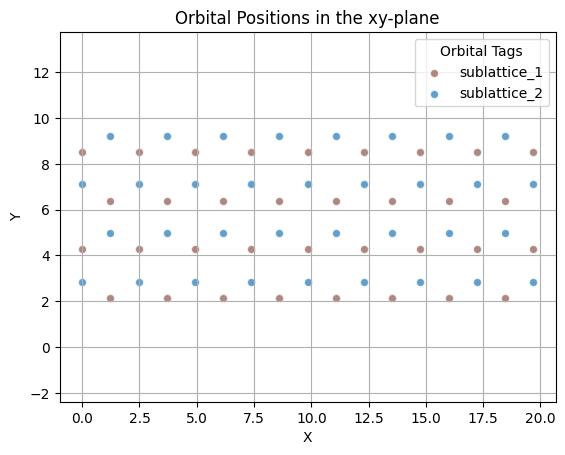

In [1]:
from granad import Wave, Orbital, OrbitalList, MaterialCatalog, Rectangle

flake = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )
flake.show_2d()

If we have a stack

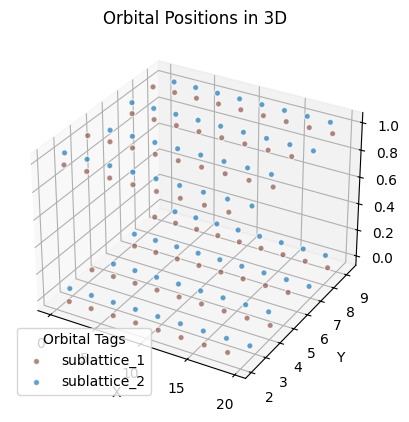

In [2]:
flake_shifted = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )
flake_shifted.shift_by_vector( "sublattice_1", [0,0,1] )
flake_shifted.shift_by_vector( "sublattice_2", [0,0,1] )
stack = flake + flake_shifted
stack.show_3d()

## Time-dependent arrays

There is a dedicated function for processing TD simulation output

In [3]:
help(flake.show_time_dependence)

Help on method show_time_dependence in module granad._plotting:

show_time_dependence(density_matrices, operator=None, time: jax.Array = None, indicate_eigenstate=True, ylabel=None, thresh: float = 0.01) method of granad.orbitals.OrbitalList instance
    Depicts an expectation value as a function of time.


    - `density_matrices`: TxNxN array, if no operator is given, diagonal elements will be plotted
    - `operator`: if given, show its time-dependent expectation value
    - `time`: time axis
    - `indicate_eigenstate`: whether to associate the i-th energy eigenstate to the i-th column of expectation_value
    - `thresh`: plotting threshold.  o_t is plotted if max(o_t) - min(o_t) > thresh



So, lets plot the relaxing energy occupations of the first flake after exciting a HOMO-LUMO transition

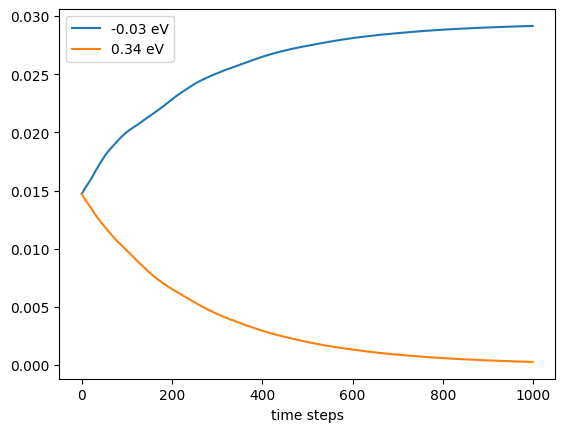

In [4]:
flake.set_excitation( flake.homo, flake.homo + 2, 1 )
time, density_matrices =  flake.get_density_matrix_time_domain(
        end_time=40,
        steps_time=1e5,
        relaxation_rate=1/10,
        illumination=Wave( [0,0,0], 0 ),
        skip=100,
)
density_matrices_e = flake.transform_to_energy_basis( density_matrices )
flake.show_time_dependence( density_matrices = density_matrices_e  )

If we want, we can check that the correct excitation is set

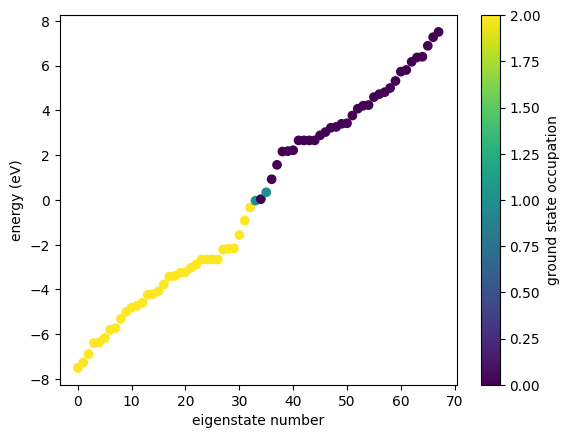

In [5]:
flake.show_energies()

## Space-dependent arrays

The functions show_2d and show_3d are a bit more versatile than initially indicated. Let's see why at the 2d example

In [6]:
help(flake.show_2d)

Help on method show_2d in module granad._plotting:

show_2d(show_tags=None, show_index=False, display=None) method of granad.orbitals.OrbitalList instance
    Generates a 2D scatter plot representing the positions of orbitals in the xy-plane,
    filtered by specified tags. Optionally colors points by eigenvector amplitudes.

    Parameters:
    - orbs (list): List of orbital objects, each with attributes 'tag' and 'position'.
    - show_tags (list of str, optional): Tags used to filter orbitals for display.
    - show_index (bool): If True, indexes of the orbitals will be shown on the plot.
    - display: N-element array to display

    Returns:
    - None: A 2D scatter plot is displayed.



So, the display argument allows us to plot an arbitrary function defined on the grid spanned by the orbitals and filter it by orbital tags. Let's demonstrate this by visualizing the lowest energy one particle state of the flake

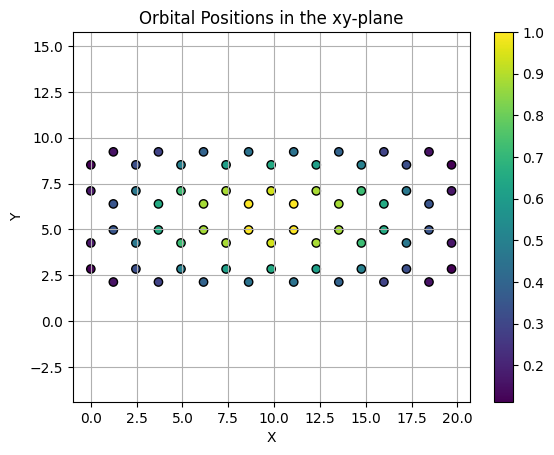

In [7]:
flake.show_2d( display = flake.eigenvectors[:, 0] ) # the ground state is the

Additionally, if you supply the keyword argument name = "MY-PLOT-NAME.pdf" to any plotting function, the plot will not be displayed, but instead saved to disk in the directory you invoked Python.